In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder


In [2]:
import gdown

output_path = 'Bank_Customer_Churn_Prediction.csv'
gdown.download('https://drive.google.com/uc?id=1cvCNt9EL-NurjFEJU-iRPG56ae535O3h', output_path, quiet=False,fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1cvCNt9EL-NurjFEJU-iRPG56ae535O3h
To: c:\Users\user\Documents\new-python-repo\ansambles\boosting_part01\Bank_Customer_Churn_Prediction.csv
100%|██████████| 562k/562k [00:00<00:00, 3.72MB/s]


'Bank_Customer_Churn_Prediction.csv'

In [3]:
data = pd.read_csv('Bank_Customer_Churn_Prediction.csv')
data.head(5)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
data['country'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [5]:
data['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [6]:
dct = {'Female': 0, 'Male': 1}
data['gender'] = data['gender'].map(dct)

In [7]:
data['gender'].unique()

array([0, 1], dtype=int64)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  int64  
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(9), object(1)
memory usage: 937.6+ KB


In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(
    data.drop(['churn', 'customer_id'], axis=1),
    data['churn'],
    test_size=0.3,
    stratify=data['churn'],
    random_state=42)

In [10]:
cat_columns = X_train.dtypes[X_train.dtypes == 'object'].index
num_columns = X_train.dtypes[X_train.dtypes != 'object'].index

In [11]:
# заменяем пропуски в количественных переменных средними
for c in num_columns:
    X_train.fillna({c: X_train[c].mean()}, inplace=True)
    X_valid.fillna({c: X_train[c].mean()}, inplace=True)

In [12]:
# заменяем пропуски в категориальных переменных модами
for c in cat_columns:
    X_train.fillna({c: X_train[c].value_counts().index[0]}, inplace=True)
    X_valid.fillna({c: X_train[c].value_counts().index[0]}, inplace=True)

In [13]:
labelenc = LabelEncoder()
for c in cat_columns:
    lbl = LabelEncoder()
    lbl.fit(X_train[c])
    X_train[c] = lbl.transform(X_train[c])
    X_valid[c] = lbl.transform(X_valid[c])

In [14]:
features = list(X_train.columns)
features

['credit_score',
 'country',
 'gender',
 'age',
 'tenure',
 'balance',
 'products_number',
 'credit_card',
 'active_member',
 'estimated_salary']

In [15]:
X_train

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
9136,595,0,1,20,4,95830.43,1,1,0,177738.98
6410,689,2,0,63,1,0.00,2,1,1,186526.12
2607,814,0,1,31,1,118870.92,1,1,0,101704.19
3201,722,0,1,20,6,0.00,2,1,0,195486.28
3330,738,0,1,18,4,0.00,2,1,1,47799.15
...,...,...,...,...,...,...,...,...,...,...
1467,624,1,0,35,0,180303.24,2,1,0,163587.90
4644,712,2,1,74,5,0.00,2,0,0,151425.82
8942,667,0,0,37,9,71786.90,2,1,1,67734.79
2935,687,2,1,35,8,100988.39,2,1,0,22247.27


In [29]:
xgb

<module 'xgboost' from 'C:\\Users\\user\\AppData\\Roaming\\Python\\Python312\\site-packages\\xgboost\\__init__.py'>

In [16]:
# создаем объекты DMatrix
dtrain = xgb.DMatrix(data=X_train,
                     label=y_train,
                     feature_names=features
                     )
dvalid = xgb.DMatrix(data=X_valid,
                     label=y_valid)

In [17]:
# задаем значения параметров и гиперпараметров
params = {
    'objective': 'binary:logistic', # Определяет задачу бинарной классификации, логистическую функцию для предсказания вероятностей
    'eta': 0.05, # Скорость обучения (learning rate)
    'max_depth': 4, # Максимальная глубина деревьев
    'seed': 42, # ranom_state, чтобы при перегрузке не менялся результат
    'eval_metric': 'auc', # AUC-ROC как метрику оценки
    'verbosity': 0 # Уровень детализации вывода информации, 0 - минимальный
}

# задаем количество итераций
num_rounds = 100

In [18]:
# задаем наборы, для которых будем отслеживать
# метрику, заданную с помощью eval_metric
evallist = [(dtrain, 'train'), (dvalid, 'valid')]
# обучаем модель с функцией потерь по умолчанию
# (логистической функцией потерь)
xgb_model = xgb.train(params, dtrain, num_rounds, evallist)

[0]	train-auc:0.81469	valid-auc:0.84008


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[1]	train-auc:0.81509	valid-auc:0.84003
[2]	train-auc:0.81513	valid-auc:0.83915
[3]	train-auc:0.81994	valid-auc:0.83898


[4]	train-auc:0.82540	valid-auc:0.84346
[5]	train-auc:0.82549	valid-auc:0.84344
[6]	train-auc:0.82595	valid-auc:0.84447
[7]	train-auc:0.83111	valid-auc:0.84830
[8]	train-auc:0.83309	valid-auc:0.84964
[9]	train-auc:0.83554	valid-auc:0.85349
[10]	train-auc:0.83799	valid-auc:0.85433
[11]	train-auc:0.83809	valid-auc:0.85486
[12]	train-auc:0.83957	valid-auc:0.85553
[13]	train-auc:0.84038	valid-auc:0.85572
[14]	train-auc:0.84099	valid-auc:0.85643
[15]	train-auc:0.84117	valid-auc:0.85716
[16]	train-auc:0.84181	valid-auc:0.85743
[17]	train-auc:0.84442	valid-auc:0.86039
[18]	train-auc:0.84367	valid-auc:0.85940
[19]	train-auc:0.84479	valid-auc:0.86026
[20]	train-auc:0.84614	valid-auc:0.86136
[21]	train-auc:0.84689	valid-auc:0.86184
[22]	train-auc:0.84663	valid-auc:0.86118
[23]	train-auc:0.84766	valid-auc:0.86192
[24]	train-auc:0.84913	valid-auc:0.86274
[25]	train-auc:0.84979	valid-auc:0.86285
[26]	train-auc:0.85053	valid-auc:0.86347
[27]	train-auc:0.85067	valid-auc:0.86274
[28]	train-auc:0.85151

In [19]:
# записываем вероятности
preds_prob = xgb_model.predict(dvalid)
# вычисляем AUC-ROC на проверочной выборке
print("AUC-ROC на проверочной выборке: {:.3f}".format(
    roc_auc_score(y_valid, preds_prob)))

AUC-ROC на проверочной выборке: 0.877


In [20]:
# пишем пользовательскую логистическую функцию потерь,
# добавив понижающую корректировку гессиана
def custom_obj(preds, dtrain):
    labels = dtrain.get_label()
    preds = 1.0 / (1.0 + np.exp(-preds))
    grad = preds - labels
    hess_correction = 0.02
    hess = preds * (1.0 - preds) - hess_correction
    return grad, hess

In [31]:
# задаем значения параметров и гиперпараметров
params2 = {
    'eta': 0.05,
    'max_depth': 4,
    'seed': 42,
    'eval_metric': 'auc',
    'verbosity': 0
}
xgb_model_custom_loss = xgb.train(params2,
                                  dtrain,
                                  num_boost_round=100,
                                  evals=evallist,
                                  obj=custom_obj)

[0]	train-auc:0.81476	valid-auc:0.84053
[1]	train-auc:0.81564	valid-auc:0.84053
[2]	train-auc:0.82297	valid-auc:0.84275
[3]	train-auc:0.82576	valid-auc:0.84646
[4]	train-auc:0.82777	valid-auc:0.84616
[5]	train-auc:0.82937	valid-auc:0.84691
[6]	train-auc:0.83216	valid-auc:0.85011
[7]	train-auc:0.83114	valid-auc:0.84894
[8]	train-auc:0.83285	valid-auc:0.85058
[9]	train-auc:0.83328	valid-auc:0.85075
[10]	train-auc:0.83640	valid-auc:0.85235
[11]	train-auc:0.83719	valid-auc:0.85341
[12]	train-auc:0.83755	valid-auc:0.85295
[13]	train-auc:0.83843	valid-auc:0.85468
[14]	train-auc:0.83855	valid-auc:0.85497
[15]	train-auc:0.83980	valid-auc:0.85547
[16]	train-auc:0.84061	valid-auc:0.85583
[17]	train-auc:0.84136	valid-auc:0.85665
[18]	train-auc:0.84089	valid-auc:0.85647
[19]	train-auc:0.84183	valid-auc:0.85719
[20]	train-auc:0.84184	valid-auc:0.85734
[21]	train-auc:0.84463	valid-auc:0.85949
[22]	train-auc:0.84591	valid-auc:0.86101
[23]	train-auc:0.84684	valid-auc:0.86143
[24]	train-auc:0.84804	val

In [37]:
xgb_model_custom_loss.attributes

<bound method Booster.attributes of <xgboost.core.Booster object at 0x000002CE93D36120>>

In [22]:
# записываем вероятности
preds_prob = xgb_model_custom_loss.predict(dvalid)
# вычисляем AUC-ROC на проверочной выборке
print("AUC-ROC на проверочной выборке: {:.3f}".format(
    roc_auc_score(y_valid, preds_prob)))

AUC-ROC на проверочной выборке: 0.877


In [23]:
# обучаем модель с функцией потерь по умолчанию (логистической
# функцией потерь), используя перекрестную проверку
xgb.cv(params,
       dtrain,
       num_boost_round=100,
       nfold=5,
       as_pandas=True,
       show_stdv=True,
       stratified=True,
       verbose_eval=True,
       shuffle=True)

[0]	train-auc:0.81609+0.00303	test-auc:0.80587+0.01389
[1]	train-auc:0.81859+0.00285	test-auc:0.80784+0.01320
[2]	train-auc:0.82108+0.00143	test-auc:0.81289+0.01534
[3]	train-auc:0.82526+0.00177	test-auc:0.81625+0.01824
[4]	train-auc:0.82851+0.00369	test-auc:0.81699+0.01461
[5]	train-auc:0.82993+0.00279	test-auc:0.82006+0.01742
[6]	train-auc:0.83182+0.00347	test-auc:0.82165+0.01511
[7]	train-auc:0.83311+0.00422	test-auc:0.82344+0.01560
[8]	train-auc:0.83531+0.00458	test-auc:0.82612+0.01619
[9]	train-auc:0.83758+0.00410	test-auc:0.82786+0.01691
[10]	train-auc:0.83903+0.00400	test-auc:0.82989+0.01640
[11]	train-auc:0.84026+0.00362	test-auc:0.83037+0.01695
[12]	train-auc:0.84120+0.00402	test-auc:0.83157+0.01705
[13]	train-auc:0.84247+0.00357	test-auc:0.83280+0.01695
[14]	train-auc:0.84277+0.00386	test-auc:0.83364+0.01708
[15]	train-auc:0.84340+0.00362	test-auc:0.83419+0.01693
[16]	train-auc:0.84396+0.00347	test-auc:0.83482+0.01726
[17]	train-auc:0.84447+0.00351	test-auc:0.83517+0.01703
[1

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.816093,0.003032,0.805868,0.013892
1,0.818592,0.002849,0.807836,0.013201
2,0.821076,0.001433,0.812890,0.015340
3,0.825259,0.001771,0.816249,0.018241
4,0.828507,0.003694,0.816988,0.014610
...,...,...,...,...
95,0.886235,0.002946,0.853860,0.012485
96,0.886463,0.002839,0.854017,0.012490
97,0.886784,0.002881,0.853893,0.012564
98,0.886955,0.002927,0.853963,0.012431


In [24]:
# обучаем модель с пользовательской логистической функцией
# потерь, используя перекрестную проверку
xgb.cv(params2,
       dtrain,
       num_boost_round=100,
       nfold=5,
       obj=custom_obj,
       as_pandas=True,
       show_stdv=True,
       stratified=True,
       verbose_eval=True,
       shuffle=True)

[0]	train-auc:0.81208+0.00297	test-auc:0.80397+0.01548
[1]	train-auc:0.81744+0.00415	test-auc:0.80931+0.01906
[2]	train-auc:0.82045+0.00510	test-auc:0.80939+0.01771
[3]	train-auc:0.82476+0.00672	test-auc:0.81593+0.01759
[4]	train-auc:0.82867+0.00476	test-auc:0.82077+0.01601
[5]	train-auc:0.83092+0.00491	test-auc:0.82262+0.01547
[6]	train-auc:0.83242+0.00287	test-auc:0.82441+0.01663
[7]	train-auc:0.83298+0.00318	test-auc:0.82614+0.01617
[8]	train-auc:0.83534+0.00345	test-auc:0.82721+0.01646
[9]	train-auc:0.83597+0.00306	test-auc:0.82893+0.01714
[10]	train-auc:0.83684+0.00297	test-auc:0.82928+0.01681
[11]	train-auc:0.83813+0.00340	test-auc:0.82934+0.01703
[12]	train-auc:0.83835+0.00330	test-auc:0.82974+0.01718
[13]	train-auc:0.83940+0.00350	test-auc:0.83101+0.01707
[14]	train-auc:0.84012+0.00347	test-auc:0.83146+0.01708
[15]	train-auc:0.84112+0.00377	test-auc:0.83292+0.01695
[16]	train-auc:0.84236+0.00379	test-auc:0.83420+0.01675
[17]	train-auc:0.84334+0.00384	test-auc:0.83483+0.01704
[1

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.812085,0.002972,0.803966,0.015483
1,0.817441,0.004145,0.809306,0.019056
2,0.820446,0.005098,0.809394,0.017714
3,0.824762,0.006718,0.815925,0.017587
4,0.828668,0.004757,0.820770,0.016012
...,...,...,...,...
95,0.888800,0.002608,0.853919,0.013158
96,0.889089,0.002683,0.853926,0.013079
97,0.889298,0.002731,0.854084,0.013054
98,0.889480,0.002786,0.854081,0.012966


In [25]:
# увеличим количество итераций
num_rounds = 1000

# обучаем модель, используя
# раннюю остановку
xgb_model_earlystop = xgb.train(params,
                                dtrain,
                                num_rounds,
                                evallist,
                                early_stopping_rounds=10)

[0]	train-auc:0.81469	valid-auc:0.84008
[1]	train-auc:0.81509	valid-auc:0.84003
[2]	train-auc:0.81513	valid-auc:0.83915
[3]	train-auc:0.81994	valid-auc:0.83898
[4]	train-auc:0.82540	valid-auc:0.84346
[5]	train-auc:0.82549	valid-auc:0.84344
[6]	train-auc:0.82595	valid-auc:0.84447
[7]	train-auc:0.83111	valid-auc:0.84830
[8]	train-auc:0.83309	valid-auc:0.84964
[9]	train-auc:0.83554	valid-auc:0.85349
[10]	train-auc:0.83799	valid-auc:0.85433
[11]	train-auc:0.83809	valid-auc:0.85486
[12]	train-auc:0.83957	valid-auc:0.85553


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[13]	train-auc:0.84038	valid-auc:0.85572
[14]	train-auc:0.84099	valid-auc:0.85643
[15]	train-auc:0.84117	valid-auc:0.85716
[16]	train-auc:0.84181	valid-auc:0.85743
[17]	train-auc:0.84442	valid-auc:0.86039
[18]	train-auc:0.84367	valid-auc:0.85940
[19]	train-auc:0.84479	valid-auc:0.86026
[20]	train-auc:0.84614	valid-auc:0.86136
[21]	train-auc:0.84689	valid-auc:0.86184
[22]	train-auc:0.84663	valid-auc:0.86118
[23]	train-auc:0.84766	valid-auc:0.86192
[24]	train-auc:0.84913	valid-auc:0.86274
[25]	train-auc:0.84979	valid-auc:0.86285
[26]	train-auc:0.85053	valid-auc:0.86347
[27]	train-auc:0.85067	valid-auc:0.86274
[28]	train-auc:0.85151	valid-auc:0.86318
[29]	train-auc:0.85247	valid-auc:0.86371
[30]	train-auc:0.85300	valid-auc:0.86401
[31]	train-auc:0.85390	valid-auc:0.86473
[32]	train-auc:0.85444	valid-auc:0.86521
[33]	train-auc:0.85491	valid-auc:0.86521
[34]	train-auc:0.85559	valid-auc:0.86595
[35]	train-auc:0.85610	valid-auc:0.86598
[36]	train-auc:0.85663	valid-auc:0.86639
[37]	train-auc:0

In [26]:
# печатаем наилучшее значение AUC-ROC и номер наилучшей итерации
print("наилучшее значение AUC-ROC: %.5f" % xgb_model_earlystop.best_score)
print("номер наилучшей итерации:", xgb_model_earlystop.best_iteration)

наилучшее значение AUC-ROC: 0.87819
номер наилучшей итерации: 123


In [27]:
# обучаем модель, используя перекрестную проверку
# и раннюю остановку
xgb.cv(params,
       dtrain,
       num_boost_round=1000,
       nfold=5,
       as_pandas=True,
       show_stdv=True,
       stratified=True,
       verbose_eval=True,
       early_stopping_rounds=5,
       shuffle=True)

[0]	train-auc:0.81609+0.00303	test-auc:0.80587+0.01389
[1]	train-auc:0.81859+0.00285	test-auc:0.80784+0.01320
[2]	train-auc:0.82108+0.00143	test-auc:0.81289+0.01534
[3]	train-auc:0.82526+0.00177	test-auc:0.81625+0.01824
[4]	train-auc:0.82851+0.00369	test-auc:0.81699+0.01461
[5]	train-auc:0.82993+0.00279	test-auc:0.82006+0.01742
[6]	train-auc:0.83182+0.00347	test-auc:0.82165+0.01511
[7]	train-auc:0.83311+0.00422	test-auc:0.82344+0.01560
[8]	train-auc:0.83531+0.00458	test-auc:0.82612+0.01619
[9]	train-auc:0.83758+0.00410	test-auc:0.82786+0.01691
[10]	train-auc:0.83903+0.00400	test-auc:0.82989+0.01640
[11]	train-auc:0.84026+0.00362	test-auc:0.83037+0.01695
[12]	train-auc:0.84120+0.00402	test-auc:0.83157+0.01705
[13]	train-auc:0.84247+0.00357	test-auc:0.83280+0.01695
[14]	train-auc:0.84277+0.00386	test-auc:0.83364+0.01708
[15]	train-auc:0.84340+0.00362	test-auc:0.83419+0.01693
[16]	train-auc:0.84396+0.00347	test-auc:0.83482+0.01726
[17]	train-auc:0.84447+0.00351	test-auc:0.83517+0.01703
[1

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.816093,0.003032,0.805868,0.013892
1,0.818592,0.002849,0.807836,0.013201
2,0.821076,0.001433,0.812890,0.015340
3,0.825259,0.001771,0.816249,0.018241
4,0.828507,0.003694,0.816988,0.014610
...,...,...,...,...
92,0.885193,0.003098,0.853757,0.012688
93,0.885655,0.002896,0.853997,0.012748
94,0.885958,0.002816,0.853783,0.012626
95,0.886235,0.002946,0.853860,0.012485


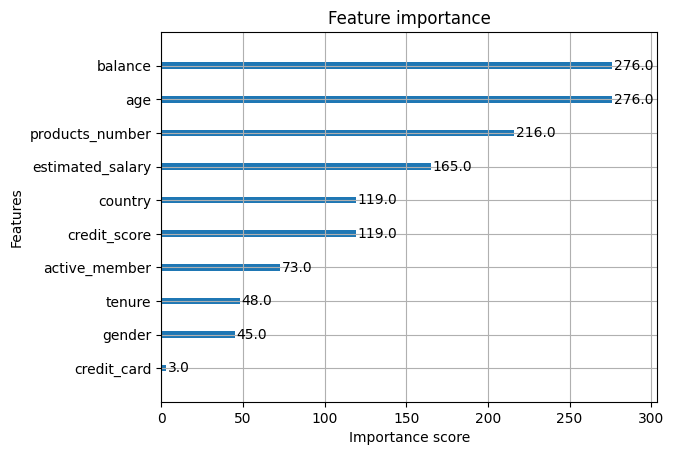

In [28]:
# строим график важностей, тип важности - вес
xgb.plot_importance(xgb_model, importance_type='weight');

Важные гиперпараметры для XGBoost включают:

n_estimators: количество деревьев.  
learning_rate (или eta): скорость обучения.  
max_depth: максимальная глубина деревьев.  
min_child_weight: минимальное количество образцов для разделения узла.  
subsample: доля выборки для каждого дерева.  
colsample_bytree, colsample_bylevel, colsample_bynode: доля признаков, используемых на различных уровнях.  
gamma: минимальное уменьшение потерь для разделения узла.

**colsample_bytree**:

Определяет долю случайных признаков, которые используются для построения каждого дерева в ансамбле.
Если colsample_bytree равен 0.8, это означает, что 80% признаков будет случайно выбрано для построения каждого дерева, а оставшиеся 20% не будут использоваться в этом дереве.
Помогает уменьшить переобучение и улучшить обобщающую способность модели.



**colsample_bylevel**:

Определяет долю случайных признаков, которые используются на каждом уровне дерева.
Например, если colsample_bylevel равен 0.8, то на каждом уровне дерева будет использоваться только 80% всех признаков, а оставшиеся 20% не будут использованы на этом уровне.
Это параметр помогает избежать переобучения, особенно если у вас много признаков и модель может переобучаться на слишком многих признаках.




**colsample_bynode**:

Определяет долю случайных признаков, которые используются при рассмотрении каждого узла дерева.
Если colsample_bynode равен 0.8, это означает, что для каждого узла будет использоваться только 80% всех признаков, а остальные 20% будут проигнорированы при принятии решения о разделении узла.
Этот параметр помогает в создании более разнообразных деревьев и улучшает устойчивость модели.
